In [1]:
import os
import joblib
import pandas as pd
import numpy as np


import sys
sys.path.append('/data/Hydra_Work/Competition_Functions') 
from Processing_Functions import process_forecast_date, process_seasonal_forecasts
from Data_Transforming import read_nested_csvs, generate_daily_flow, use_USGS_flow_data, USGS_to_daily_df_yearly

sys.path.append('/data/Hydra_Work/Pipeline_Functions')
from Folder_Work import filter_rows_by_year, csv_dictionary, add_day_of_year_column

In [2]:
# All the prep
monthly_basins = ['animas_r_at_durango', 'boise_r_nr_boise', 'boysen_reservoir_inflow', 'colville_r_at_kettle_falls', 'detroit_lake_inflow', 'dillon_reservoir_inflow',
    'fontenelle_reservoir_inflow', 'green_r_bl_howard_a_hanson_dam', 'hungry_horse_reservoir_inflow', 'libby_reservoir_inflow',
    'missouri_r_at_toston','owyhee_r_bl_owyhee_dam', 'pecos_r_nr_pecos', 'pueblo_reservoir_inflow',
    'ruedi_reservoir_inflow', 'skagit_ross_reservoir', 'snake_r_nr_heise', 'stehekin_r_at_stehekin', 'sweetwater_r_nr_alcova',
    'taylor_park_reservoir_inflow', 'virgin_r_at_virtin', 'weber_r_nr_oakley', 'yampa_r_nr_maybell',
]


USGS_basins = ['animas_r_at_durango', 'boise_r_nr_boise', 'boysen_reservoir_inflow', 'colville_r_at_kettle_falls', 'detroit_lake_inflow', 'dillon_reservoir_inflow',   
    'green_r_bl_howard_a_hanson_dam', 'hungry_horse_reservoir_inflow', 'libby_reservoir_inflow', 'merced_river_yosemite_at_pohono_bridge', 'missouri_r_at_toston',
    'owyhee_r_bl_owyhee_dam', 'pecos_r_nr_pecos', 'pueblo_reservoir_inflow',    'san_joaquin_river_millerton_reservoir', 'snake_r_nr_heise', 'stehekin_r_at_stehekin',
    'sweetwater_r_nr_alcova', 'taylor_park_reservoir_inflow', 'virgin_r_at_virtin', 'weber_r_nr_oakley', 'yampa_r_nr_maybell',
]

basins = list(set(monthly_basins + USGS_basins))


selected_years = range(2000,2024,2)

era5_folder = '/data/Hydra_Work/Rodeo_Data/era5'
era5 = csv_dictionary(era5_folder, basins, years=selected_years)
era5 = add_day_of_year_column(era5)

flow_folder = '/data/Hydra_Work/Rodeo_Data/train_monthly_naturalized_flow'
flow = csv_dictionary(flow_folder, monthly_basins)
flow = filter_rows_by_year(flow, 1998)

climatology_file_path = '/data/Hydra_Work/Rodeo_Data/climate_indices.csv'
climate_indices = pd.read_csv(climatology_file_path)
climate_indices['date'] = pd.to_datetime(climate_indices['date'])
climate_indices.set_index('date', inplace = True)
climate_indices.drop('Unnamed: 0', axis = 1, inplace = True)
climate_indices = climate_indices[~climate_indices.index.duplicated(keep='first')]

root_folder = '/data/Hydra_Work/Rodeo_Data/seasonal_forecasts'
seasonal_forecasts = read_nested_csvs(root_folder)

USGS_flow_folder = '/data/Hydra_Work/Rodeo_Data/USGS_streamflows'
USGS_flow = csv_dictionary(USGS_flow_folder, USGS_basins)

Static_variables = pd.read_csv('/data/Hydra_Work/Rodeo_Data/static_indices.csv', index_col= 'site_id')

# Convert monthly flow values to daily flow estimates
daily_flow = {}

# Iterate through the dictionary and apply generate_daily_flow to each DataFrame
for key, df in flow.items():
    daily_flow[key] = generate_daily_flow(df, persistence_factor=0.7)

# Replacing monhtly data for normalised USGS when available
daily_flow = use_USGS_flow_data(daily_flow, USGS_flow)


normalising_basins = ['san_joaquin_river_millerton_reservoir', 'merced_river_yosemite_at_pohono_bridge', 'detroit_lake_inflow']

for basin in normalising_basins:
    path = f'/data/Hydra_Work/Rodeo_Data/USGS_streamflows/{basin}.csv' 
    normalising_path = f'/data/Hydra_Work/Rodeo_Data/train_yearly/{basin}.csv'
    USGS_to_daily_df_yearly(daily_flow, path, basin, normalising_path)



In [24]:
import matplotlib.pyplot as plt




,daily_flow
date,
1998-01-01,0.429905
1998-01-02,0.441725
1998-01-03,0.473334
1998-01-04,0.461912
1998-01-05,0.461873
...,...
2022-06-26,1.188108
2022-06-27,2.241339
2022-06-28,1.816873


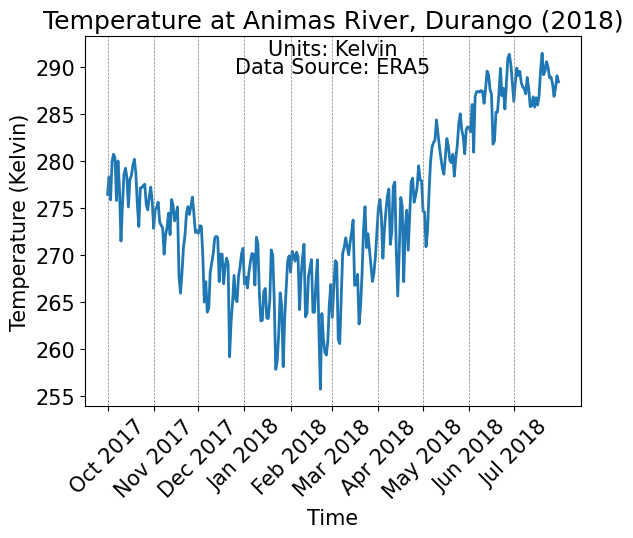

In [29]:
# plt.rcParams.update({'font.size': plt.rcParams['font.size'] + 5})
plt.plot(era5['animas_r_at_durango_2018']['temperature'], linewidth = 2)

# Set labels and title
plt.xlabel('Time')  # Assuming time is on the x-axis
plt.ylabel('Temperature (Kelvin)')
plt.title('Temperature at Animas River, Durango (2018)')

# Add units and data source information
plt.text(0.5, 0.95, 'Units: Kelvin', horizontalalignment='center', transform=plt.gca().transAxes)
plt.text(0.5, 0.90, 'Data Source: ERA5', horizontalalignment='center', transform=plt.gca().transAxes)



# Get the start of each month
monthly_starts = era5['animas_r_at_durango_2018'].resample('MS').first()

# Set x-ticks to represent the start of each month
plt.xticks(monthly_starts.index, 
           [x.strftime('%b %Y') for x in monthly_starts.index], 
           rotation=45)

# Show markers only at the start of each month
for month_start in monthly_starts.index:
    plt.axvline(x=month_start, color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

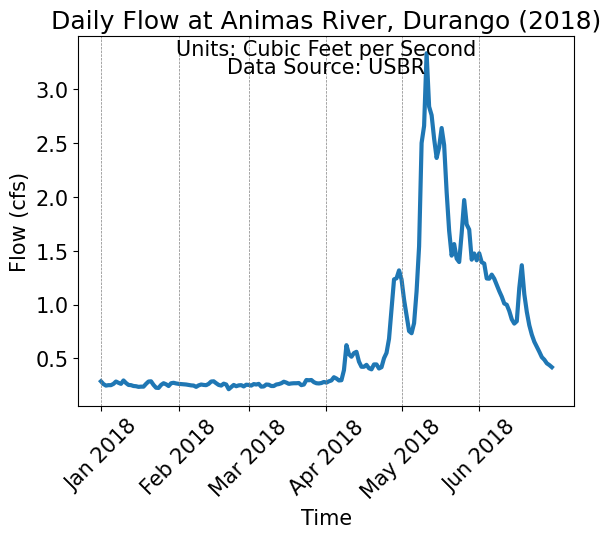

In [31]:
daily_flow_2018 = daily_flow['animas_r_at_durango'][daily_flow['animas_r_at_durango'].index.year == 2018]

# Plot the daily flow data for 2018
plt.plot(daily_flow_2018, linewidth = 3)

# Set labels and title
plt.xlabel('Time')  # Assuming time is on the x-axis
plt.ylabel('Flow (cfs)')  # Assuming flow data is in cubic feet per second
plt.title('Daily Flow at Animas River, Durango (2018)')

# Add units and data source information
plt.text(0.5, 0.95, 'Units: Cubic Feet per Second', horizontalalignment='center', transform=plt.gca().transAxes)
plt.text(0.5, 0.90, 'Data Source: USBR', horizontalalignment='center', transform=plt.gca().transAxes)

# Get the start of each month for 2018
monthly_starts_2018 = daily_flow_2018.resample('MS').first()

# Set x-ticks to represent the start of each month
plt.xticks(monthly_starts_2018.index, 
           [x.strftime('%b %Y') for x in monthly_starts_2018.index], 
           rotation=45)

# Show markers only at the start of each month
for month_start in monthly_starts_2018.index:
    plt.axvline(x=month_start, color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

DatetimeIndex(['2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04',
               '2017-10-05', '2017-10-06', '2017-10-07', '2017-10-08',
               '2017-10-09', '2017-10-10',
               ...
               '2018-07-22', '2018-07-23', '2018-07-24', '2018-07-25',
               '2018-07-26', '2018-07-27', '2018-07-28', '2018-07-29',
               '2018-07-30', '2018-07-31'],
              dtype='datetime64[ns]', name='date', length=304, freq=None)

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Static
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Static_variables)
joblib.dump(scaler, f'/data/Hydra_Work/Rodeo_Data/scalers/static_scaler.save')


# Daily Flow
for basin, dataframe in daily_flow.items(): 
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataframe)
    # scaled_dataframe = pd.DataFrame(scaled_data, columns=dataframe.columns)
    joblib.dump(scaler, f'/data/Hydra_Work/Rodeo_Data/scalers/flows/{basin}_flow_scaler.save')
    

# Climate_Indices
climate_scaler_filename = '/data/Hydra_Work/Rodeo_Data/scalers/climate_normalization_scaler.save'
scaler = StandardScaler()
scaled_data = scaler.fit_transform(climate_indices)
joblib.dump(scaler, climate_scaler_filename)


# Era5
Flat_Era5 = pd.concat(era5.values(), ignore_index=True)
era5_scaler_filename = '/data/Hydra_Work/Rodeo_Data/scalers/era5_scaler.save'
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Flat_Era5)
joblib.dump(scaler, era5_scaler_filename)


# SEAS5
Flat_SEAS5 = pd.concat(seasonal_forecasts.values(), ignore_index=True)
seasonal_scaler_filename = "/data/Hydra_Work/Rodeo_Data/scalers/seasonal_scaler.save"
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Flat_SEAS5)
joblib.dump(scaler, seasonal_scaler_filename)

['/data/Hydra_Work/Rodeo_Data/scalers/seasonal_scaler.save']

In [ ]:
seasonal_scaler_filename = "/data/Hydra_Work/Rodeo_Data/scalers/seasonal_scaler.save"
seasonal_forecasts = {key: pd.DataFrame(seasonal_scaler.transform(df), columns=df.columns, index=df.index ) for key, df in seasonal_forecasts.items()}

static_scaler_filename = '/data/Hydra_Work/Rodeo_Data/scalers/static_scaler.save'

